In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from cell_inference.config import params, paths

In [2]:
geo_file = 'cell_inference/resources/geom_parameters_reduced_order_L5_full.csv'
select_sec = [8, 9, 10]
geo_standard = pd.read_csv(geo_file, index_col='id')
sec_df = geo_standard.loc[select_sec]

In [3]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json'
with open(filepath) as f:
    biophys_param = json.load(f)

section_type = 'apic'
for genome in biophys_param['genome']:
    if genome['section']==section_type and genome['name']=='g_pas':
        gl = float(genome['value'])
    if genome['section']==section_type and genome['name']=='e_pas':
        el = float(genome['value'])

In [4]:
# total membrane area (um2)
area = np.sum(2 * np.pi * sec_df['L'].values * sec_df['R'].values)

In [5]:
# total number of synapses
n_exc = sec_df['exc_dens'].values * sec_df['L'].values
n_inh = sec_df['inh_dens'].values * sec_df['L'].values
print('Number of synapses (exc, inh)')
print(n_exc, n_inh)
# average firing interval (ms)
intvl_exc = 1000 / (sec_df['excFRmean'].values * sec_df['excP_0mean'].values)
intvl_inh = 1000/ (sec_df['inhFRmean'].values * sec_df['inhP_0mean'].values)
print('Inter spike interval (ms)')
print(intvl_exc, intvl_inh)

Number of synapses (exc, inh)
[ 121.8 1293.6  243.6] [23.1 46.2 46.2]
Inter spike interval (ms)
[425.91251757 425.91251757 425.91251757] [854.7008547 854.7008547 854.7008547]


In [6]:
# average proportion of synapse maximal conductance gbar
# alpha: 1/rise time constant, beta: 1/decay time constant, Cdur: on duration, intvl: time interval between events. (ms)
def R_avg(a, b, C, T):
    if C <= T:
        R = a / (a + b) * ( C + (a / b + np.exp(-C * (a + b))) * (1 - np.exp((C - T) * b)) / (a + b) ) / T 
    else:
        R = a / (a + b)
    return R

In [7]:
# single synapse conductance (uS), r - average proportion
r_nmda = np.array([R_avg(.2659, 0.008, 16.7650, intvl) for intvl in intvl_exc])
r_ampa = np.array([R_avg(1.52, 0.14, 0.7254, intvl) for intvl in intvl_exc])
r_gaba = np.array([R_avg(3.8142, 0.1429, 1.4210, intvl) for intvl in intvl_exc])
# g_bar * weight * proportion
g_nmda = .5e-3 * 0.2 * r_nmda
g_ampa = 1e-3 * 0.2 * r_ampa
g_gaba = 1e-3 * 1 * r_gaba
print('Average proportion of synapse maximal conductance')
print(r_nmda, r_ampa, r_gaba)

# total synapse conductance (uS)
g_nmda = np.sum(n_exc * g_nmda)
g_ampa = np.sum(n_exc * g_ampa)
g_gaba = np.sum(n_inh * g_gaba)

print('Total leak conductance (uS)')
g_leak = gl * area * 1e-2  # S/cm2 * um2 -> uS => * 1e-2
print(g_leak)

print('Synapse conductances (uS)')
g_list = [g_nmda, g_ampa, g_gaba]
print(g_list)

Average proportion of synapse maximal conductance
[0.30440868 0.30440868 0.30440868] [0.01600919 0.01600919 0.01600919] [0.01848307 0.01848307 0.01848307]
Total leak conductance (uS)
0.0005878492630039106
Synapse conductances (uS)
[0.050501400597287215, 0.005311849501554243, 0.0021347945067452185]


In [8]:
# calculated equivalent conductance and reversal potential
# list of g and e
def equiv_g_e(g, e):
    G = np.sum(g)
    E = np.dot(g, e) / G
    return G, E

In [9]:
# calculated equivalent conductance and reversal potential
e_list = [0., 0., -75.]  # reversal potential (mV)
g_syn, e_syn = equiv_g_e(g_list, e_list)
print('Total synapse conductance (uS)')
print(g_syn)

g_syn = g_syn / area * 1e2  # uS / um2 -> S/cm2
print('Total synapse conductance (S/cm2), Reveral potential (mV)')
print(g_syn, e_syn)

g_tot, e_tot = equiv_g_e((g_syn, gl), (e_syn, el))
print('Leak conductance (S/cm2), Reveral potential (mV)')
print(g_leak, el)
print('Equivalent conductance (S/cm2), Equivalent reveral potential (mV)')
print(g_tot, e_tot)

Total synapse conductance (uS)
0.057948044605586675
Total synapse conductance (S/cm2), Reveral potential (mV)
0.005806148007786734 -2.7629851722460965
Leak conductance (S/cm2), Reveral potential (mV)
0.0005878492630039106 -72.0
Equivalent conductance (S/cm2), Equivalent reveral potential (mV)
0.005865048007786733 -3.4583009084413447


In [10]:
gs_syn = np.logspace(np.log10(gl/100), np.log10(g_syn), 100)
gs, es = np.hsplit(np.array([equiv_g_e((g, gl), (e_syn, el)) for g in gs_syn]), 2)

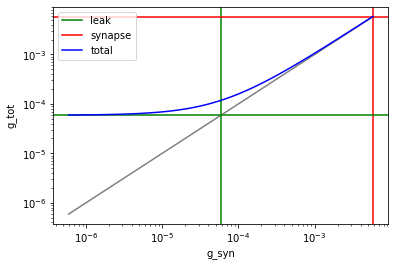

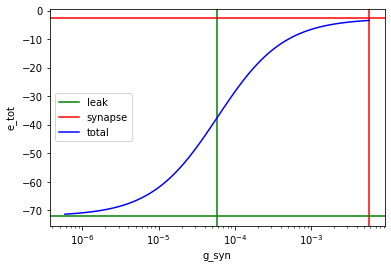

In [11]:
plt.figure()
plt.plot(gs_syn, gs_syn, 'grey')
plt.axvline(x=gl, color='g', label='leak')
plt.axvline(x=g_syn, color='r', label='synapse')
plt.axhline(y=gl, color='g')
plt.axhline(y=g_syn, color='r')
plt.plot(gs_syn, gs, 'b', label='total')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('g_syn')
plt.ylabel('g_tot')
plt.legend()

plt.figure()
plt.axvline(x=gl, color='g', label='leak')
plt.axvline(x=g_syn, color='r', label='synapse')
plt.axhline(y=el, color='g')
plt.axhline(y=e_syn, color='r')
plt.plot(gs_syn, es, 'b', label='total')
plt.xscale('log')
plt.xlabel('g_syn')
plt.ylabel('e_tot')
plt.legend()

plt.show()